## Draw a grid and add population data

Grid with a designated cell size based on city OSM name, without all the cells outside of administrative borders and completely in the water, added population data based on geocoded housing in notebook 2.

In [57]:
import geopandas as gpd
import pandas as pd

from shapely.geometry import Point, LineString, Polygon
from shapely.geometry import box

import matplotlib.pyplot as plt
import numpy as np

# maps libraries
import folium
from pyproj import CRS
import contextily as ctx
import osmnx as ox

import warnings
warnings.filterwarnings('ignore')

C:\Users\UX306\anaconda3\envs\gis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
# reading api keys
api_keys = pd.read_excel('../api_keys.xlsx')
api_keys.set_index('key_name', inplace=True)

# link for mapbox map as a underlay for folium
map_url = api_keys.loc['mapbox_map']['key']

### contents

1. [Input data](#1)
2. [Creating grid in UTM](#2)
3. [Deleting cells in the water and outside of admin boundaries](#3)
4. [Creating centroids, convert to 4326, saving grid and centroids](#4)
5. [See the result on folium map](#5)
6. [Add population data, see the result on static map](#6)

## 1. Input data <a class="anchor" id="1"></a>

We need only the city name and the cell size, all the rest can be done automatically by requesting OSM, HERE and Yandex APIs.

In [59]:
# long place name for geocoding in OSM
place_name = 'городское поселение Альметьевск'

In [60]:
cell_size = 250

In [61]:
# espg for UTM CRS
# can be found via https://www.latlong.net/lat-long-utm.html and https://spatialreference.org/
espg = 32639

In [62]:
# Get place boundary related to the place name as a geodataframe
area = ox.geocode_to_gdf(place_name)

#grid cells CRS
area.crs = CRS.from_epsg(4326).to_wkt()

# Check data values
area

,geometry,place_name,bbox_north,bbox_south,bbox_east,bbox_west
0,"POLYGON ((52.20360 54.92292, 52.20461 54.91989...","Almetyevsk, Almetyevsky District, Tatarstan, V...",54.950882,54.850074,52.462423,52.203597


<AxesSubplot:>

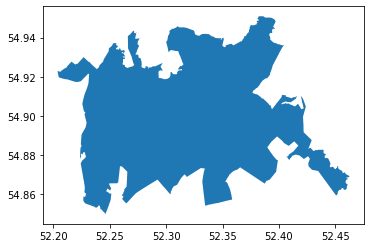

In [63]:
# Plot the area:
area.plot()

In [64]:
# south-west bounding box coordinates from OSM
sw_lat, sw_lon = area['bbox_south'][0], area['bbox_west'][0]

# north-east bounding box coordinates from OSM
ne_lat, ne_lon  = area['bbox_north'][0], area['bbox_east'][0]

# center point coordinates
center_lon = area['geometry'].centroid.map(lambda p: p.x)
center_lat = area['geometry'].centroid.map(lambda p: p.y)

## 2. Geodataframe with grid and centroid coordinates <a class="anchor" id="2"></a>

#### 2.1 Geodataframe with bounding box

In [65]:
#polygon out of bounding box
poly = box(minx=sw_lon, miny=sw_lat, maxx=ne_lon, maxy=ne_lat)
print(poly)

POLYGON ((52.4624232 54.8500741, 52.4624232 54.9508817, 52.2035972 54.9508817, 52.2035972 54.8500741, 52.4624232 54.8500741))


In [66]:
#create new empty geodataframe
newdata = gpd.GeoDataFrame()
# Create a new column called 'geometry' to the GeoDataFrame
newdata['geometry'] = None

# Insert the polygon into 'geometry' -column at row 0
newdata.at[0, 'geometry'] = poly

newdata.crs = CRS.from_epsg(4326).to_wkt()

In [67]:
#convert to UTM CRS
newdata_wgs = newdata.to_crs(espg)
newdata_wgs.crs.to_epsg()

32639

#### 2.2 Geodataframe with grid cells

We create grid in UTM CRS, create centroids out of it in UTM and then reproject all of it into 4326 and use 4326 for all the calculations later.

In [68]:
# bounding box it utm
sw_lon_utm, sw_lat_utm = newdata_wgs.geometry.bounds['minx'][0], newdata_wgs.geometry.bounds['miny'][0]
ne_lon_utm, ne_lat_utm = newdata_wgs.geometry.bounds['maxx'][0], newdata_wgs.geometry.bounds['maxy'][0]

#number of cells per side
lat_n_cells = int((ne_lat_utm-sw_lat_utm) / cell_size)
lon_n_cells = int((ne_lon_utm-sw_lon_utm) / cell_size)

lat_n_cells, lon_n_cells

(46, 67)

In [69]:
# create the cells in a loop
grid_cells_utm = []
for x0 in np.arange(sw_lon_utm, sw_lon_utm+cell_size*lon_n_cells, cell_size):
    for y0 in np.arange(sw_lat_utm, sw_lat_utm+cell_size*lat_n_cells, cell_size):
        # bounds
        x1 = x0+cell_size
        y1 = y0+cell_size
        grid_cells_utm.append(box(x0, y0, x1, y1)  )

# geodataframe with cells
grid_cells_utm = gpd.GeoDataFrame(grid_cells_utm, columns=['geometry'])

#grid cells UTM CRS
grid_cells_utm.crs = CRS.from_epsg(espg).to_wkt()

In [70]:
#create unique id for cells
grid_cells_utm = grid_cells_utm.reset_index().rename(columns={'index':'id'})

## 3. Deleting cells in the water and outside of admin boundaries <a class="anchor" id="3"></a>

#### 3.1 delete the cells completely outside admin boundaries

We already have the `area` Geodataframe, which contains admin boundaries for our city; we reproject it in UTM.

In [71]:
# reproject area to UTM
area_utm = area.to_crs(epsg=espg)
# Are the layers in the same projection?
area_utm.crs == grid_cells_utm.crs

True

In [72]:
# delete grid cells outside of admin area
grid_cells_utm = gpd.sjoin(grid_cells_utm, area_utm, how="inner", op="intersects")

#delete extra columns
grid_cells_utm.drop(['index_right', 'place_name', 
                 'bbox_north', 'bbox_south', 'bbox_east', 'bbox_west'], axis=1,inplace=True)

print ('Number of cells inside admin area - ', len(grid_cells_utm))

Number of cells inside admin area -  1730


#### 3.2 delete cells completely in the water

We create `water` Geodataframe from OSM data inside our `area` box.

In [73]:
# tags for water
tags = {'natural': 'water'}

In [74]:
# Get the water inside area data
water = ox.geometries_from_place(place_name, tags)
# Check the result
print("Retrieved", len(water), "objects")

# reproject water to UTM
water_utm = water.to_crs(epsg=espg)

# Are the layers in the same projection?
water_utm.crs == grid_cells_utm.crs

Retrieved 22 objects


True

In [75]:
# find grid cells completely in the water
cells_in_water = gpd.sjoin(grid_cells_utm, water_utm, how="inner", op="within")

print ('Number of cells inside completely in the water - ', len(cells_in_water))

#remove completely in the water cells from main grid geodataframe
condition = grid_cells_utm['id'].isin(cells_in_water['id'])
grid_cells_utm.drop(grid_cells_utm[condition].index, inplace = True)

print ('Number of cells inside admin area and outside of water - ', len(grid_cells_utm))

Number of cells inside completely in the water -  6
Number of cells inside admin area and outside of water -  1724


C:\Users\UX306\anaconda3\envs\gis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 4. Creating centroids, convert to 4326, saving grid and centroids <a class="anchor" id="4"></a>

#### 4.1 Creating centroids, convert to 4326

In [76]:
# centroids from grid in CRS 4326
centroids = grid_cells_utm.centroid.to_crs(epsg=4326)

#GDF out of geoseries
centroids = gpd.GeoDataFrame(geometry=gpd.GeoSeries(centroids))

#columns with lon lat
centroids['lon'] = centroids['geometry'].map(lambda p: p.x)
centroids['lat'] = centroids['geometry'].map(lambda p: p.y)

# id from grid to centroids
centroids = gpd.sjoin(centroids, grid_cells_utm.to_crs(epsg=4326), how="inner", op="within").drop('index_right',axis=1)

centroids.head()

C:\Users\UX306\anaconda3\envs\gis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,geometry,lon,lat,id
30,POINT (52.20458 54.91859),52.204584,54.918592,30
31,POINT (52.20465 54.92084),52.204651,54.920838,31
32,POINT (52.20472 54.92308),52.204718,54.923084,32
76,POINT (52.20848 54.91855),52.208483,54.918553,76
77,POINT (52.20855 54.92080),52.208550,54.920800,77


In [77]:
# number of cells inside a bounding box
print ('Number of centroids inside admin area and outside of water - ', len(centroids))

Number of centroids inside admin area and outside of water -  1724


C:\Users\UX306\anaconda3\envs\gis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### 4.2 Saving grid and centroids

In [78]:
# write the centroids in 4326 to Shapefile
centroids.to_file("./input_data/centroid.shp")

In [79]:
# write the grid in UTM to Shapefile
grid_cells_utm.to_file("./input_data/grid.shp")

## 5. Grid on map <a class="anchor" id="5"></a>

In [80]:
m = folium.Map(location=[center_lat, center_lon], tiles = map_url, zoom_start = 11, control_scale=True, attr = 'Mapbox')

#Convert cells to GeoJSON, add to map
folium.GeoJson(
   grid_cells_utm.to_crs(epsg=3857),
    name='grid layer'
).add_to(m)

#Convert admin boundaries to GeoJSON, add to map
folium.GeoJson(
   area.to_crs(epsg=3857),
    name='admin boundaries'
).add_to(m)

    
m

## 6. Population data and map <a class="anchor" id="6"></a>

In [81]:
# read population data
pop = gpd.read_file('./input_data/2housing_test.shp')
# convert to UTM
pop_utm = pop.to_crs(epsg=espg)
pop_utm.crs == grid_cells_utm.crs

True

In [82]:
# convert quarters number to population
total_population = 158429

coef_people_in_quarters = total_population/pop_utm['quarters_c'].sum()

# population in point
pop_utm['population'] = pop_utm['quarters_c']*coef_people_in_quarters

In [83]:
# spatial join
merged = gpd.sjoin(pop_utm, grid_cells_utm, how='left', op='within')
dissolve = merged.dissolve(by='index_right', aggfunc='sum')
grid_cells_utm.loc[dissolve.index, 'population_reform']=dissolve['population'].values

C:\Users\UX306\anaconda3\envs\gis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


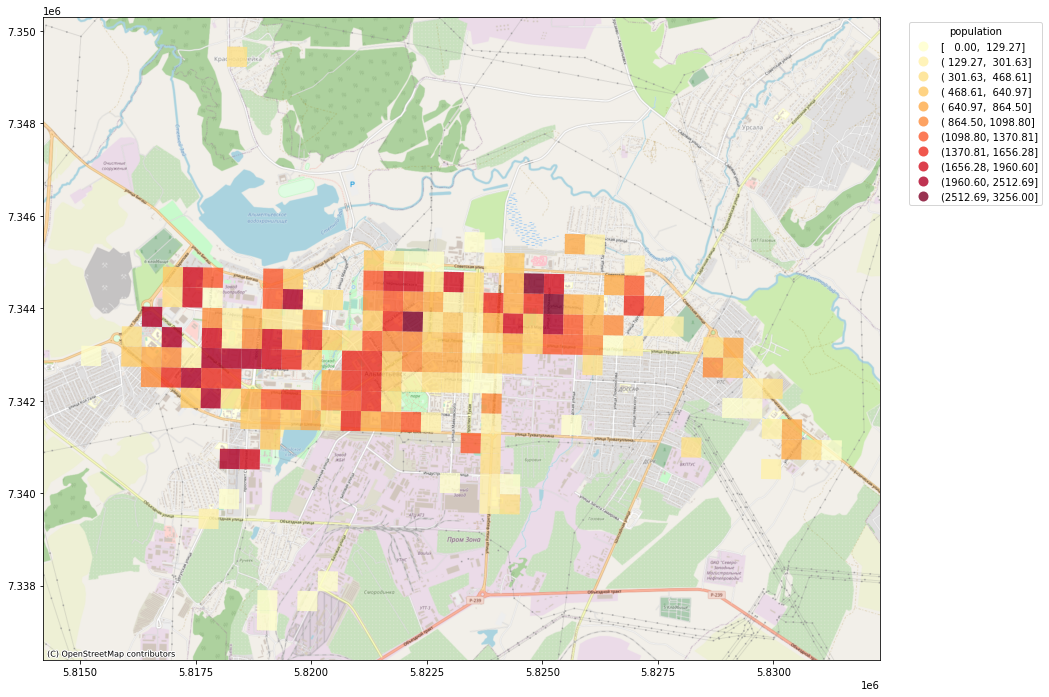

In [84]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(15,15))

# Plot the data
grid_cells_utm.to_crs(epsg=3857).plot(ax=ax, column='population_reform', cmap='YlOrRd', linewidth=0, 
                            scheme="Natural_Breaks", k=11, alpha=0.8, legend=True)

# Re-position the legend and set a title
ax.get_legend().set_bbox_to_anchor((1.2,1))
ax.get_legend().set_title("population")


# Add basemap with basic OpenStreetMap visualization
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)